<h1> Assignment 3: Group Project </h1>

In [590]:
# import libraries

import matplotlib.pyplot as plt
from matplotlib import pyplot
%matplotlib inline

import pandas as pd
import numpy as np
import seaborn as sns
import re

# 1. Data preparation and exploration

## 1.1 Data Retrieving

In [591]:
movies_df = pd.read_csv('data/movies.csv', delimiter=',')
ratings_df = pd.read_csv('data/ratings.csv', delimiter=',')

C:\Users\Laptop\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [592]:
movies_df.head()

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0
3,False,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",...,1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,"[{'id': 35, 'name': 'Comedy'}]",NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,...,1995-02-10,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0


In [593]:
ratings_df.head()

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


## 1.2 Data cleaning and preparation

In [594]:
#set threshold
threshold = 0.65

# dropping columns with missing value rate higher than threshold
ratings_df = ratings_df[ratings_df.columns[ratings_df.isnull().mean() < threshold]]

# Remove the missing values from the rows having greater or equal to 6 missing values.
movies_df = movies_df[movies_df.isnull().sum(axis=1) <= 6]
ratings_df = ratings_df[ratings_df.isnull().sum(axis=1) <= 6]

### 1.2.1 Handle missing data

In [595]:
# Percentage of missing value in movies_df before cleaning
percent_missing = movies_df.isnull().sum() * 100 / len(movies_df)
missing_values = pd.DataFrame({'percent_missing': percent_missing})
missing_values.sort_values(by ='percent_missing' , ascending=False)

,percent_missing
belongs_to_collection,90.121447
homepage,82.887442
tagline,55.091085
overview,2.081317
poster_path,0.825046
runtime,0.547831
status,0.178210
release_date,0.169409
imdb_id,0.035202
original_language,0.024201


In [596]:
# Filling missing value for movies dataset

movies_df["tagline"] = movies_df["tagline"].fillna("Unknown")

movies_df["overview"] = movies_df["overview"].fillna("Unknown")

movies_df["poster_path"] = movies_df["poster_path"].fillna("Unknown")

movies_df["runtime"] = movies_df["runtime"].fillna(method='ffill')

movies_df["release_date"] = movies_df["release_date"].fillna(method='ffill')

movies_df["status"] = movies_df["status"].fillna(movies_df['status'].mode()[0])

movies_df["imdb_id"] = movies_df["imdb_id"].fillna(method='ffill')

movies_df["original_language"] = movies_df["original_language"].fillna(movies_df['original_language'].mode()[0])

In [597]:
# Percentage of missing value in movies_df after cleaning
percent_missing = movies_df.isnull().sum() * 100 / len(movies_df)
missing_values = pd.DataFrame({'percent_missing': percent_missing})
missing_values.sort_values(by ='percent_missing' , ascending=False)

,percent_missing
belongs_to_collection,90.121447
homepage,82.887442
adult,0.000000
production_countries,0.000000
vote_average,0.000000
video,0.000000
title,0.000000
tagline,0.000000
status,0.000000
spoken_languages,0.000000


In [598]:
# Percentage of missing value in ratings_df before cleaning
percent_missing = ratings_df.isnull().sum() * 100 / len(ratings_df)
missing_values = pd.DataFrame({'percent_missing': percent_missing})
missing_values.sort_values(by ='percent_missing' , ascending=False)

,percent_missing
userId,0.0
movieId,0.0
rating,0.0
timestamp,0.0


In [599]:
ratings_df = ratings_df.dropna(how='any',axis=0) 

In [600]:
# Percentage of missing value in ratings_df before cleaning
percent_missing = ratings_df.isnull().sum() * 100 / len(ratings_df)
missing_values = pd.DataFrame({'percent_missing': percent_missing})
missing_values.sort_values(by ='percent_missing' , ascending=False)

,percent_missing
userId,0.0
movieId,0.0
rating,0.0
timestamp,0.0


In [601]:
# rename column id in movies_df to match movieId with ratings_df
movies_df.rename(columns={"id": "movieId"}, inplace=True)

In [602]:
# Check type for movies_df
movies_df.dtypes

adult                     object
belongs_to_collection     object
budget                    object
genres                    object
homepage                  object
movieId                   object
imdb_id                   object
original_language         object
original_title            object
overview                  object
popularity                object
poster_path               object
production_companies      object
production_countries      object
release_date              object
revenue                  float64
runtime                  float64
spoken_languages          object
status                    object
tagline                   object
title                     object
video                     object
vote_average             float64
vote_count               float64
dtype: object

In [603]:
# Check type for ratings_df
ratings_df.dtypes

userId         int64
movieId        int64
rating       float64
timestamp      int64
dtype: object

In [604]:
# Delete row in movieId column contain string value
movies_df = movies_df[~movies_df['movieId'].isin(['1997-08-20', '2012-09-29','2014-01-01'])]

In [605]:
# change column type for movies_df
movies_df["movieId"] = pd.to_numeric(movies_df['movieId'])

movies_df["popularity"] = pd.to_numeric(movies_df['popularity'])

movies_df["budget"] = pd.to_numeric(movies_df['budget'])

Each movie has many ratings rated by many different users. We calculate the average ratings of one movie by sum all the ratings of one movie and divide by the number of ratings.

In [606]:
ratings_df = ratings_df.groupby(['movieId']).mean().groupby('movieId')['rating'].mean().reset_index()

In [607]:
df = movies_df.merge(ratings_df, how="left", on="movieId")

In [608]:
df['rating'].isnull().sum()

42621

As the number of movies which do not have rating is very high(42621); therefore, we need to handle missing data. In order to do that, we see that in the data frame it has the "imdbid" column. Therefore,we will use that column to crawl the updated data.of movie rating of IMDB website. When doing this, we can make sure the movie rating is accurate and updated as well as taking care of missing rating in movies.

Refer to "imdb_crawler" folder , we have created the python script to crawl rating from IMDB website and then we output the updated ratings.csv file.

In [609]:
# Load new ratings.csv file
ratings_updated_df = pd.read_csv("imdb_crawler/ratings.csv", delimiter=",")

In [610]:
# Percentage of missing value in ratings_updated_df before cleaning
percent_missing = ratings_updated_df.isnull().sum() * 100 / len(ratings_updated_df)
missing_values = pd.DataFrame({'percent_missing': percent_missing})
missing_values.sort_values(by ='percent_missing' , ascending=False)

,percent_missing
rating,0.059458
movieId,0.000000


As the percentage of missing values in rating column is very low (0.05%), we can safely drop the rows with missing values.

In [611]:
ratings_updated_df['rating'] = ratings_updated_df['rating'].dropna(how='any',axis=0)

In [612]:
ratings_updated_df = ratings_updated_df.groupby(['movieId']).mean().groupby('movieId')['rating'].mean().reset_index()

In [613]:
df_updated = movies_df.merge(ratings_updated_df, how="left", on="movieId")

comment_counts = pd.DataFrame(df_updated["title"].value_counts())
rare_movies = comment_counts[comment_counts["title"] <= 1000].index
common_movies = df_updated[~df_updated["title"].isin(rare_movies)]
# round rating float, for classification
df_updated = df_updated.round({'rating': 0})

In [614]:
df_updated['rating'].isnull().sum()

49

In the dataset, there are some columns with array object as values. We would like to convert to array string based on the field name

In [615]:
from ast import literal_eval

def split_genres(row):
    row['genres'] = ",".join([info['name'] for info in literal_eval(row['genres'])])
    return row

def split_prod_countries(row):
    row['production_countries'] = ",".join([info['name'] for info in literal_eval(row['production_countries'])])
    return row

def split_prod_companies(row):
    row['production_companies'] = ",".join([info['name'] for info in literal_eval(row['production_companies'])])
    return row

def split_spoken_languages(row):
    row['spoken_languages'] = ",".join([info['name'] for info in literal_eval(row['spoken_languages'])])
    return row
  
df_updated = df_updated.apply(split_genres, axis=1)
df_updated = df_updated.apply(split_prod_countries, axis=1)
df_updated = df_updated.apply(split_prod_companies, axis=1)
df_updated = df_updated.apply(split_spoken_languages, axis=1)

In [616]:
# function for text cleaning
def clean_text(text):
    # remove backslash-apostrophe
    text = re.sub("\'", "", text)
    # remove everything alphabets
    text = re.sub(r"(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?", "", text)
    # remove whitespaces
    text = ' '.join(text.split())
    # remove double whote inside
    text = text.replace('“', '').replace('”', '').replace('"', '')
    # remove number
    text = re.sub(r"\d+", "", text)
    # convert text to lowercase
    text = text.lower()
    
    return text

In [617]:
# Apply clean_text function for cleaning text
df_updated['title'] = df_updated['title'].apply(lambda x: clean_text(x))
df_updated['tagline'] = df_updated['tagline'].apply(lambda x: clean_text(x))
df_updated['original_title'] = df_updated['original_title'].apply(lambda x: clean_text(x))
df_updated['overview'] = df_updated['overview'].apply(lambda x: clean_text(x))

In [618]:
# Remove stopword
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

# function to remove stopwords
def remove_stopwords(text):
    no_stopword_text = [w for w in text.split() if not w in stop_words]
    return ' '.join(no_stopword_text)
  
df_updated['overview'] = df_updated['overview'].apply(lambda x: remove_stopwords(x))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Laptop\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## 1.3 Data Exploration

Chart 1: Movies produced by Countries

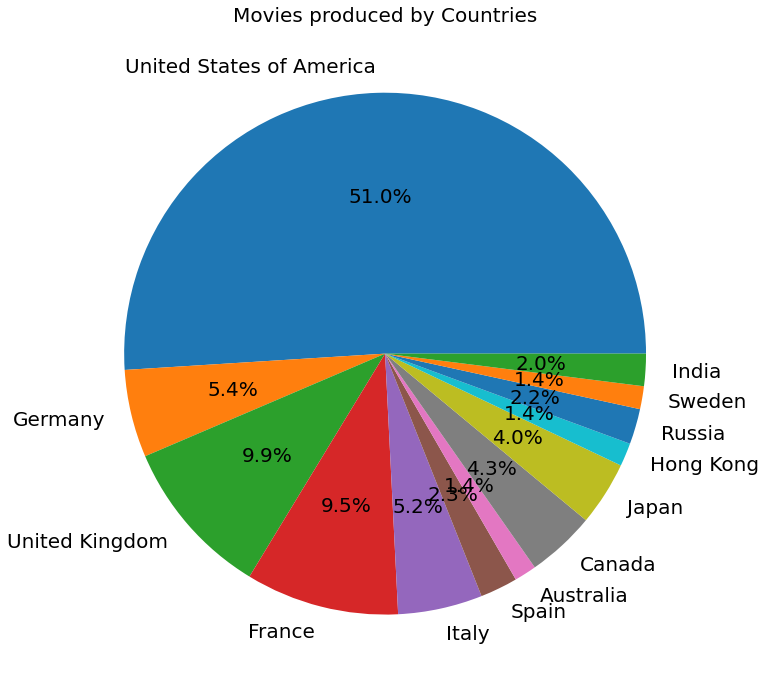

In [619]:
from collections import Counter

a=[]
for each in df_updated.production_countries.str.split(","):
    for i in each:
        a.append(i)
        
b = dict(Counter(a))

keys=[]
values=[]

for key,value in b.items() :
    if value > 500 and key != "":
        keys.append(key)
        values.append(value)

       
labels = keys
colors = sns.color_palette()
explode =[0,0,0,0,0,0,0,0,0,0,0,0,0]
sizes= values
    
plt.figure(figsize = (20,12))

plt.pie(sizes,explode = explode,labels=labels,colors = colors,autopct='%1.1f%%',textprops= {"fontsize": 20},shadow = False)
plt.title("Movies produced by Countries", fontsize=20)

plt.show()

Chart 2: Number of movie types

Text(0.5, 1.0, 'Number of movie types')

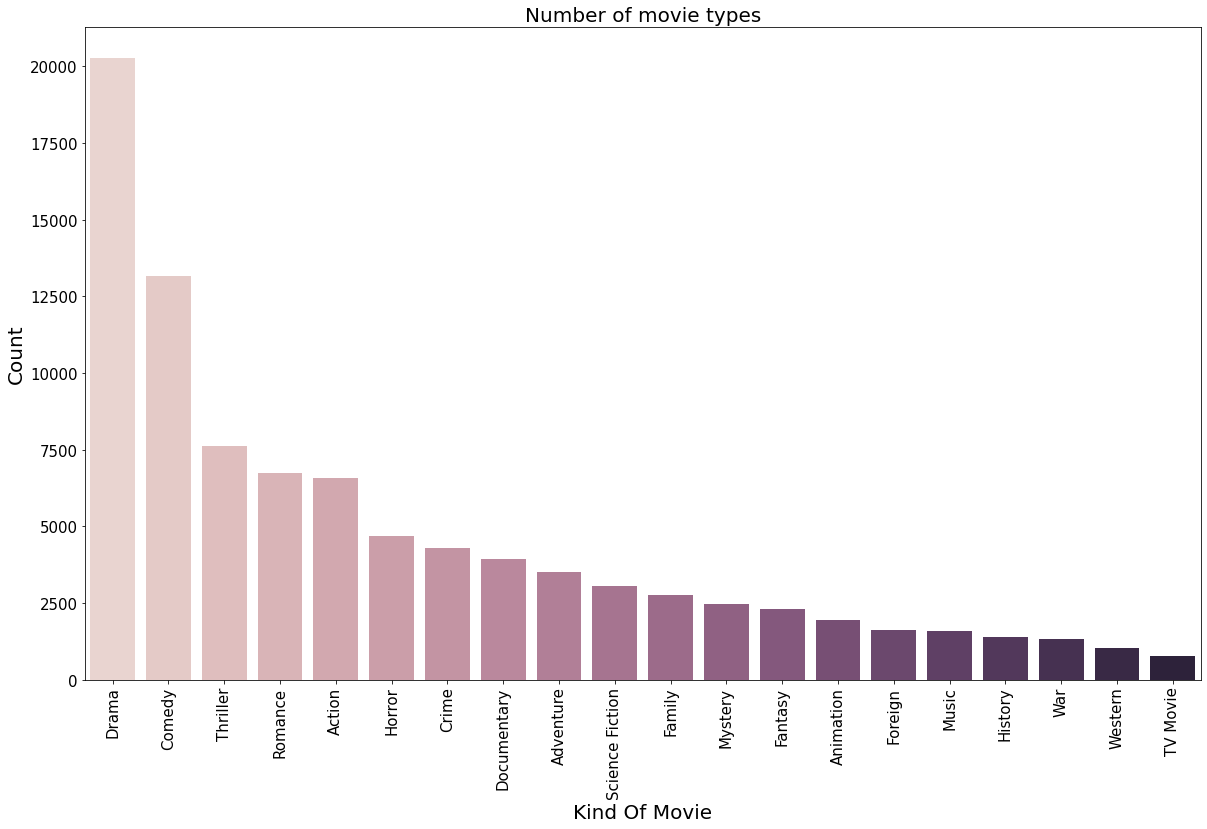

In [620]:
from collections import Counter

data = df_updated.genres.copy()

list_kind = data.str.split(",")
a = []
for each in list_kind:
    for i in each:
        a.append(i)
        
c=[]
for each in a:
    if each != "":
         c.append(each)        
        
f= dict(Counter(c))

df3 = pd.DataFrame(list(f.items()),columns = ["kind","ratio"])
new_index =( df3.ratio.sort_values(ascending=False)).index.values
new = df3.reindex(new_index)

plt.figure( figsize = (20,12))
plt.tick_params(labelsize = 15)
sns.barplot(x="kind",y="ratio",data=new,palette = sns.cubehelix_palette(len(f)))
plt.xticks(rotation = 90)
plt.xlabel("Kind Of Movie",fontsize=20)
plt.ylabel("Count",fontsize=20)
plt.title("Number of movie types",fontsize = 20)

Chart 3: Count each type of ratings

<ipython-input-621-e241a564035b>:3: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([num for num in ax.get_yticks()])


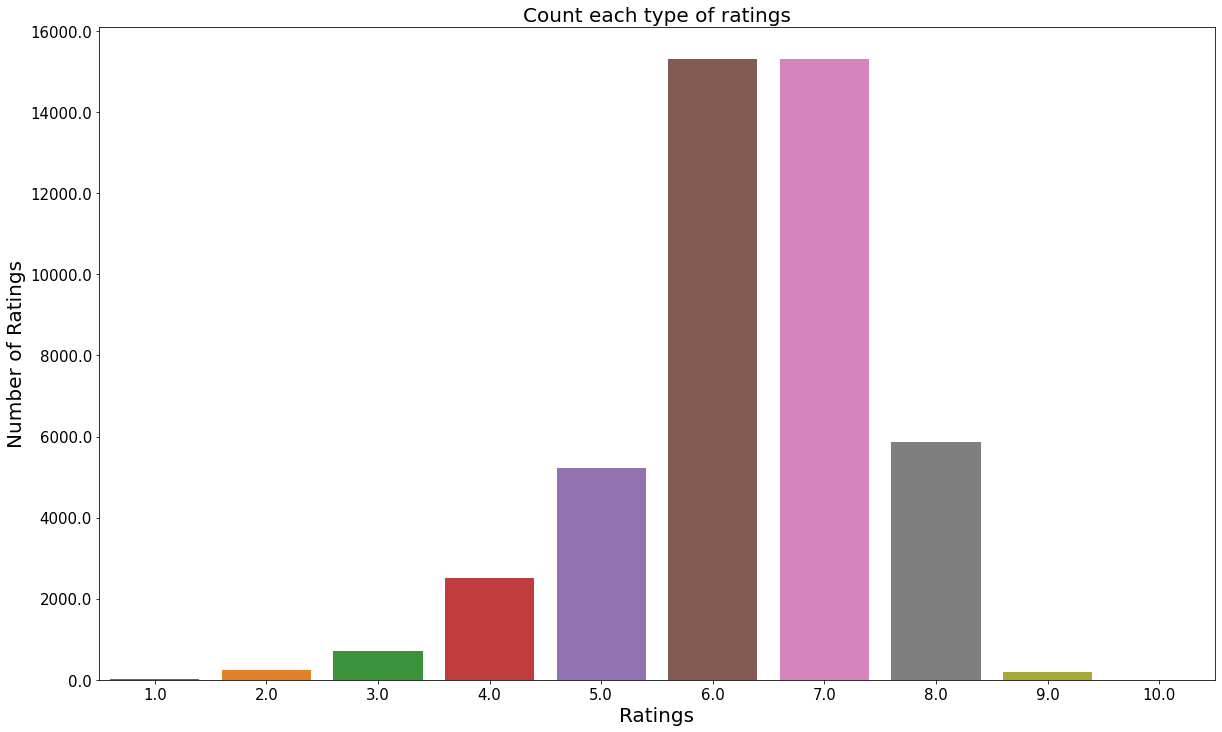

In [621]:
f,ax = plt.subplots(1,1,figsize=(20,12))
ax = sns.countplot(x="rating", data=ratings_updated_df)
ax.set_yticklabels([num for num in ax.get_yticks()])
plt.tick_params(labelsize = 15)
plt.title("Count each type of ratings", fontsize = 20)
plt.xlabel("Ratings", fontsize = 20)
plt.ylabel("Number of Ratings", fontsize = 20)
plt.show()

Chart 4: Popular Movies

Text(0.5, 1.0, 'Popular Movies')

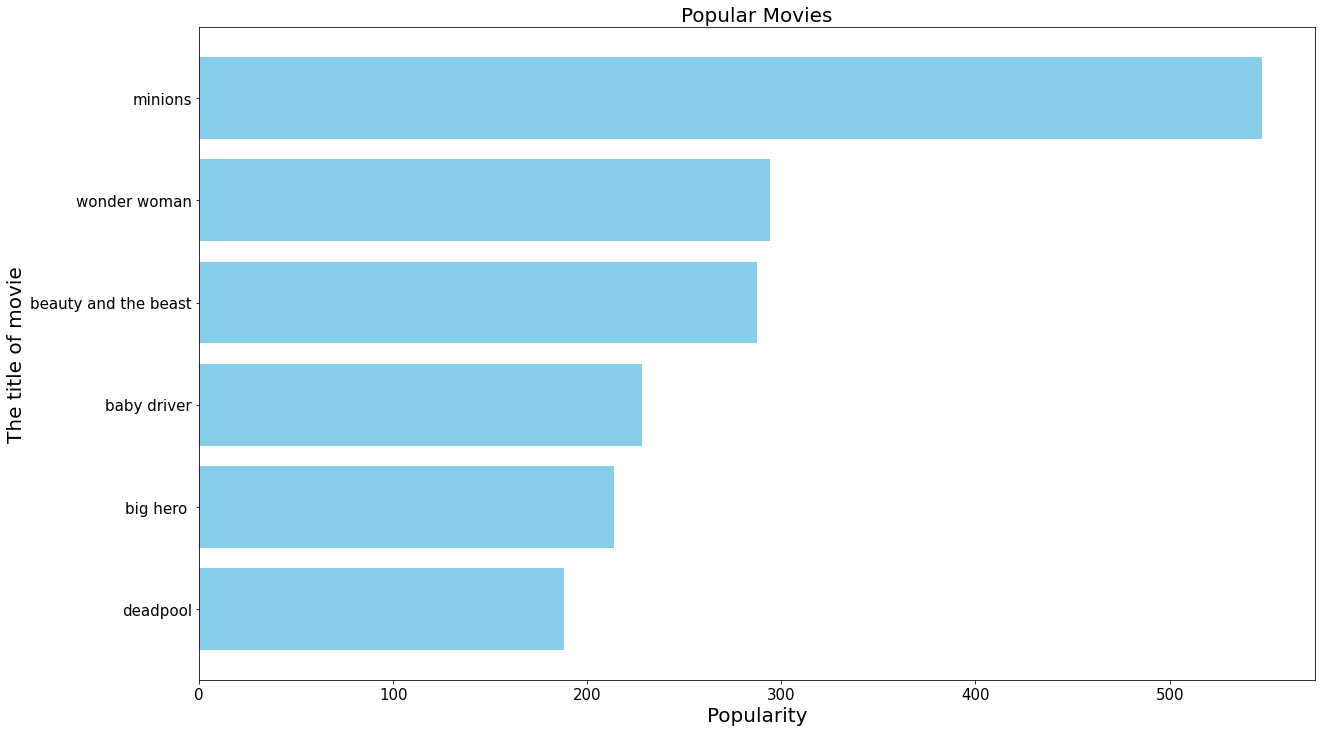

In [622]:
pop = df_updated.sort_values('popularity', ascending=False)
plt.figure(figsize=(20,12))

plt.barh(pop['title'].head(6),pop['popularity'].head(6), align='center',
        color='skyblue')
plt.gca().invert_yaxis()
plt.tick_params(labelsize = 15)
plt.xlabel("Popularity", fontsize = 20)
plt.ylabel("The title of movie", fontsize = 20)
plt.title("Popular Movies", fontsize = 20)

Chart 5: Top 6 movies with highest revenue with its budget

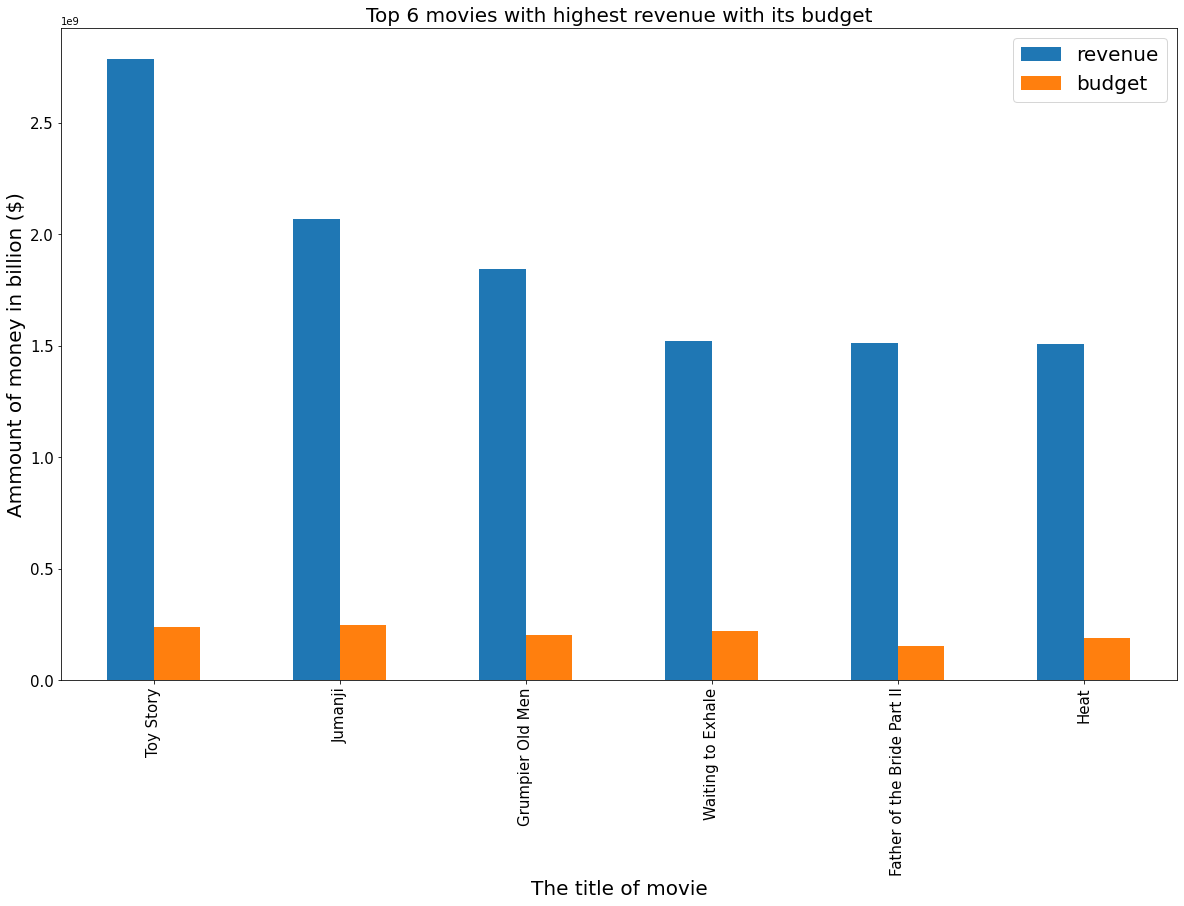

In [623]:
df1 = movies_df[['title','revenue','budget']].copy()

df1.set_index('title', inplace=True)

ax = df1.sort_values(by=['revenue'], ascending=False).head(6).plot(kind='bar', figsize=(20,12))
ax.xaxis.set_major_formatter(plt.FixedFormatter(df1.index.to_series()))
plt.tick_params(labelsize = 15)
plt.ylabel("Ammount of money in billion ($)", fontsize = 20)
plt.xlabel("The title of movie", fontsize = 20)
plt.legend(fontsize=20)
plt.title("Top 6 movies with highest revenue with its budget", fontsize = 20)
plt.show()

Chart 6: Most popular language in movies

Text(0.5, 1.0, 'Most popular language in movies')

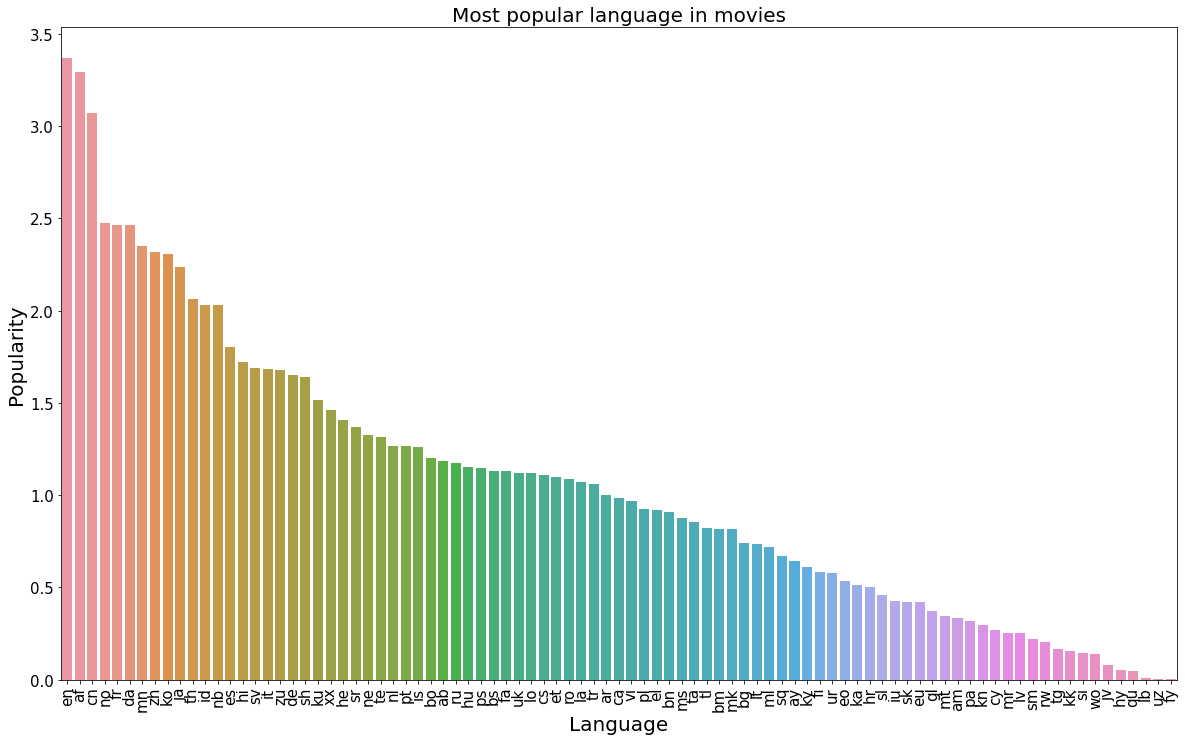

In [624]:
unique = list(movies_df.original_language.unique())
list_ratio=[]
for each in unique:
    x= movies_df[movies_df["original_language"] == each]
    ratio_popularity=sum(x.popularity)/len(x)
    list_ratio.append(ratio_popularity)
    
df1 = pd.DataFrame({"language":unique,"ratio":list_ratio})
new_index = (df1.ratio.sort_values(ascending = False)).index.values
sorted_data= df1.reindex(new_index)

#Visualization
plt.figure(figsize = (20,12))
sns.barplot(x= sorted_data["language"],y  = sorted_data["ratio"])
plt.xticks(rotation= 90)
plt.tick_params(labelsize = 15)

plt.xlabel("Language",fontsize = 20)
plt.ylabel("Popularity",fontsize = 20)
plt.title("Most popular language in movies", fontsize = 20)

# 2. Data Modelling
---

## Categorical Encoding

**belongs_to_collection**


Convert column 'belongs_to_collection' data to binary data of 0 and 1 (1 means the movie belongs to a collection, and 0 means it does not belong to any collection).

In [625]:
# converting column 'belongs_to_collection' to binary 0 and 1 data
df_updated["belongs_to_collection"] = df_updated["belongs_to_collection"].fillna(0)
df_updated["belongs_to_collection"] = np.where(df_updated["belongs_to_collection"] != 0,1,0)
df_updated['belongs_to_collection'] = pd.to_numeric(df_updated['belongs_to_collection'])

**homepage**

Convert column 'homepage' to binary data of 0 and 1 (1 means the movie has a homepage, and 0 means the movie does not have a homepage)

In [626]:
df_updated["homepage"] = df_updated["homepage"].fillna(0)
df_updated["homepage"] = np.where(df_updated["homepage"] != 0,1,0)
df_updated['homepage'] = pd.to_numeric(df_updated['homepage'])

**adult**

Convert column 'adult' data from boolean value to 1 and 0 (1: True, 0: False)

In [627]:
df_updated["adult"] = np.where(df_updated['adult'] == True, 1, 0)
df_updated['adult'] = pd.to_numeric(df_updated['adult'])

**video**

Convert column 'video' data from boolean value to 1 and 0 (1: True, 0: False)

In [628]:
df_updated["video"] = np.where(df_updated['video'] == True, 1, 0)
df_updated['video'] = pd.to_numeric(df_updated['video'])

**status**

In [629]:
df_updated['status'].value_counts()

Released           45087
Rumored              230
Post Production       98
In Production         20
Planned               15
Canceled               2
Name: status, dtype: int64

Since "Released" is the dominant value in this column, we can make the dataset easier for computing by replacing value "Released" with 1, and the others with 0.

In [630]:
df_updated["status"] = np.where(df_updated['status'] == True, 1, 0)
df_updated['status'] = pd.to_numeric(df_updated['status'])

**spoken_languages**

In [631]:
df_updated['spoken_languages'].value_counts()

English                                   22395
                                           3945
Français                                   1852
日本語                                        1289
Italiano                                   1218
                                          ...  
Deutsch,suomi,Français,Pусский,English        1
广州话 / 廣州話,普通话,Español                         1
ελληνικά,Italiano                             1
English,Français,Deutsch,Türkçe               1
Italiano,Український                          1
Name: spoken_languages, Length: 1842, dtype: int64

Same with column 'status', English is the most common language used in the movies. In addition, it also dominate other languages in terms of quantity. Therefore, we can set value 1 for movies that has English as one of the spoken language, and 0 when the movie does not use English.

In [632]:
df_updated["spoken_languages"] = np.where(df_updated['spoken_languages'].str.contains("English"), 1, 0)
df_updated['spoken_languages'] = pd.to_numeric(df_updated['spoken_languages'])

**original_language**

In [633]:
df_updated['original_language'].value_counts()

en    32278
fr     2437
it     1529
ja     1349
de     1078
      ...  
uz        1
cy        1
jv        1
tg        1
ay        1
Name: original_language, Length: 89, dtype: int64

In [634]:
df_updated["original_language"] = np.where(df_updated['original_language'] == "en", 1, 0)
df_updated['original_language'] = pd.to_numeric(df_updated['original_language'])

**production_countries**

In [635]:
df_updated['production_countries'].value_counts()

United States of America                            17851
                                                     6276
United Kingdom                                       2238
France                                               1653
Japan                                                1356
                                                    ...  
Mexico,Belgium,Netherlands,Germany,France               1
Netherlands,Spain,United States of America              1
Bulgaria,Hungary,Macedonia,Sweden,United Kingdom        1
United States of America,Bolivia                        1
Argentina,France,United Kingdom                         1
Name: production_countries, Length: 2390, dtype: int64

From a real world perspective, we can observe that the US's movie industry is gigantic. From this standpoint, we can set value of 1 for movies that involved the US in the production phase, and 0 for ther others.

In [636]:
df_updated["production_countries"] = np.where(df_updated['production_countries'].str.contains("United States of America"), 1, 0)
df_updated['production_countries'] = pd.to_numeric(df_updated['production_countries'])

**genres**

In [637]:
genre_list = []
for value in df_updated['genres'].unique():
  value_list = value.split(',')
  for item in value_list:
    genre_list.append(item.strip())

genre_list = np.unique(np.array(genre_list)).tolist()
genre_list.remove("")

for genre in genre_list:
  column_name = 'genres_' + genre
  df_updated[column_name] = np.where(df_updated['genres'].str.contains(genre), 1, 0)
    
df_updated.drop("genres",axis=1,inplace=True)

**production_companies**

In [638]:
df_updated['production_companies'].value_counts()

                                                                                                                                                         11868
Metro-Goldwyn-Mayer (MGM)                                                                                                                                  742
Warner Bros.                                                                                                                                               540
Paramount Pictures                                                                                                                                         505
Twentieth Century Fox Film Corporation                                                                                                                     439
                                                                                                                                                         ...  
Renn Productions,AMLF,Conacite Uno            

Out of over 45k movies, there are x movies that does not have any production company. In this situation, we can perform custom binary encoding for this feature, so that value 1 represents movies that has at least one production company, and reverse, value 0 represents movies that does not have any production company


In [639]:
df_updated["production_companies"] = np.where(df_updated['production_companies'] != "", 1, 0)

In [640]:
df_updated['production_companies'].value_counts()

1    33584
0    11868
Name: production_companies, dtype: int64

**release_date**

To use a datetime feature for fitting into a machine learning model, we can extract cyclical features (day, month) and encode them using sine and cosine transformation. This is to ensure that the data still keeps there cyclinal nature.
https://www.kaggle.com/avanwyk/encoding-cyclical-features-for-deep-learning

In [641]:
def encode(data, col, max_val):
    data[col + '_sin'] = np.sin(2 * np.pi * data[col]/max_val)
    data[col + '_cos'] = np.cos(2 * np.pi * data[col]/max_val)
    return data

In [642]:
df_updated['release_date']= pd.to_datetime(df_updated['release_date'])
df_updated['month'] = df_updated.release_date.dt.month
df_updated['day'] = df_updated.release_date.dt.dayofyear

print(df_updated['day'])

0        303
1        349
2        356
3        356
4         41
        ... 
45447    133
45448    321
45449    213
45450    294
45451    160
Name: day, Length: 45452, dtype: int64


In [643]:
df_updated = encode(df_updated, 'month', 12)
df_updated = encode(df_updated, 'day', 365)
# drop original unencoded features
df_updated.drop(['month', 'day', 'release_date'],axis=1,inplace=True)

## 2.1 Feature Engineering

Feature selection for fitting into the machine learning algorithms

In [644]:
df_updated.head()

,adult,belongs_to_collection,budget,homepage,movieId,imdb_id,original_language,original_title,overview,popularity,...,genres_Romance,genres_Science Fiction,genres_TV Movie,genres_Thriller,genres_War,genres_Western,month_sin,month_cos,day_sin,day_cos
0,0,1,30000000,1,862,tt0114709,1,toy story,led woody andys toys live happily room andys b...,21.946943,...,0,0,0,0,0,0,-8.660254e-01,0.5,-0.875892,0.482508
1,0,0,65000000,0,8844,tt0113497,1,jumanji,siblings judy peter discover enchanted board g...,17.015539,...,0,0,0,0,0,0,-2.449294e-16,1.0,-0.271958,0.962309
2,0,1,0,0,15602,tt0113228,1,grumpier old men,family wedding reignites ancient feud nextdoor...,11.712900,...,1,0,0,0,0,0,-2.449294e-16,1.0,-0.154309,0.988023
3,0,0,16000000,0,31357,tt0114885,1,waiting to exhale,cheated mistreated stepped women holding breat...,3.859495,...,1,0,0,0,0,0,-2.449294e-16,1.0,-0.154309,0.988023
4,0,1,0,0,11862,tt0113041,1,father of the bride part ii,george banks recovered daughters wedding recei...,8.387519,...,0,0,0,0,0,0,8.660254e-01,0.5,0.648630,0.761104


#### 2.1.1 Reasoning

In [645]:
df_updated['adult'].value_counts()

0    45452
Name: adult, dtype: int64

Because column 'adult' only contains 1 value (False), we can remove this feature from the dataset. Also, from a reality perspective, we can also drop other columns that does not predict the rating of a movies:
- imdb_id: id of the movie on imdb film review site
- movieId: id of the movie in the dataset
- poster_path: url to the poster of the movie
- original_title, title: name of the movie before and after release
- overview: a brief description about the movie
- tagline: the movie quote (usually in posters)

In [646]:
df_updated.drop(['adult','imdb_id','poster_path','title','original_title','overview','movieId','tagline'], axis=1, inplace=True)

In [647]:
first_column = df_updated.pop('rating')
df_updated.insert(0, 'rating', first_column)
df_updated.head()

,rating,belongs_to_collection,budget,homepage,original_language,popularity,production_companies,production_countries,revenue,runtime,...,genres_Romance,genres_Science Fiction,genres_TV Movie,genres_Thriller,genres_War,genres_Western,month_sin,month_cos,day_sin,day_cos
0,8.0,1,30000000,1,1,21.946943,1,1,373554033.0,81.0,...,0,0,0,0,0,0,-8.660254e-01,0.5,-0.875892,0.482508
1,7.0,0,65000000,0,1,17.015539,1,1,262797249.0,104.0,...,0,0,0,0,0,0,-2.449294e-16,1.0,-0.271958,0.962309
2,7.0,1,0,0,1,11.712900,1,1,0.0,101.0,...,1,0,0,0,0,0,-2.449294e-16,1.0,-0.154309,0.988023
3,6.0,0,16000000,0,1,3.859495,1,1,81452156.0,127.0,...,1,0,0,0,0,0,-2.449294e-16,1.0,-0.154309,0.988023
4,6.0,1,0,0,1,8.387519,1,1,76578911.0,106.0,...,0,0,0,0,0,0,8.660254e-01,0.5,0.648630,0.761104


In [648]:
df_updated['rating'].value_counts()

7.0     15337
6.0     15308
8.0      5871
5.0      5223
4.0      2503
3.0       709
2.0       250
9.0       189
1.0        12
10.0        1
Name: rating, dtype: int64

Chi square

In [649]:
from sklearn.feature_selection import chi2

X = df_updated.drop('rating',axis=1)
Y = df_updated['rating']
chi_scores = chi2(X,Y)
p_values = pd.Series(chi_scores[1],index = X.columns)
p_values.sort_values(ascending = False , inplace = True)
p_values.plot.bar()

ValueError: Input X must be non-negative.

#### 2.1.2 Correlation Matrix

In [ ]:
f,ax = plt.subplots(figsize = (20,12))
sns.heatmap (df_updated.corr(), annot = True,linewidths =0.75,linecolor = "White",fmt = ".2f",ax = ax,center = -0.1)
plt.show()

### 2.2 K-fold cross validation

In [ ]:
from sklearn.model_selection import KFold

kf5 = KFold(n_splits=5, shuffle=False)

### 2.3 Parameter tuning

### 2.4 Model training

### 2.5 Model Evaluation and Selection

### 2.6 Save the model for deployment

In this task, we use Pickle to save and load the model. Since in order to use the model outside of the notebook, we need to sae it - and then later, we can load and use it for deployment 

In [ ]:
import pickle

# pickle.dump(model1, open('model1.pkl', 'wb'))
# pickle.dump(model2, open('model2.pkl', 'wb'))
# pickle.dump(model3, open('model3.pkl', 'wb'))

## 3. Model deployment and Automation

## 4. Visualisation Dashboard